In [ ]:
import os
from glob import glob

import numpy as np
import torch
import torchvision
from pycocotools.coco import COCO

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class M18KDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.annotations = COCO(os.path.join(root, "_annotations.coco.json"))

    def __getitem__(self, idx):
        # load images and masks
        image_object = self.annotations.imgs[idx]
        img_path = image_object["file_name"]
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(os.path.join(self.root,img_path))
        masks = self.annotations.loadAnns(self.annotations.getAnnIds([image_object["id"]]))
        
        num_objs = len(masks)

        # tensor of shape [#objects,h,w] of binary masks
        binary_masks = torch.tensor(np.dstack([annotations.annToMask(mask) for mask in masks]),dtype=torch.uint8).permute([2,0,1])
        
        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(binary_masks)

        # there is only one class
        labels = torch.tensor([mask["category_id"] for mask in masks],dtype=torch.int64)

        image_id = idx
        area = torch.tensor([mask["area"] for mask in masks],dtype=torch.float32)
        # suppose all instances are not crowd
        iscrowd = torch.tensor([mask["iscrowd"] for mask in masks],dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(binary_masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            print(type(target))
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.annotations.imgs)

ds = M18KDataset("M18K/Dataset/train",None)
ds[0]

In [ ]:
annotations = COCO(os.path.join("M18K/Dataset/train", "_annotations.coco.json"))

In [ ]:
img = read_image(os.path.join("M18K/Dataset/train",annotations.imgs[0]["file_name"]))
img


In [ ]:
import numpy as np
masks = annotations.loadAnns(annotations.getAnnIds([annotations.imgs[0]["id"]]))
binary_masks = torch.tensor(np.dstack([annotations.annToMask(mask) for mask in masks]),dtype=torch.uint8).permute([2,0,1])
binary_masks.shape

In [ ]:
from M18K.Data.Dataset import M18KDataset
from M18K.Data.DataModule import M18KDataModule
from M18K.Models.TorchVision import MaskRCNN_ResNet50
from lightning import LightningModule, Trainer
from torchvision import transforms
from lightning.pytorch import loggers as pl_loggers
import argparse
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [ ]:
from M18K.Data.Dataset import M18KDataset
from M18K.Data.DataModule import M18KDataModule
from M18K.Models.TorchVision import MaskRCNN_ResNet50
from lightning import LightningModule, Trainer
from torchvision import transforms
from lightning.pytorch import loggers as pl_loggers
import argparse
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

def main(model_name="resnet_18"):
    # Instantiate the data module
    t = transforms.ToTensor()
    # if model_name == "swin_v2_b":
    #     t = transforms.Compose([transforms.ToTensor(),transforms.Grayscale()])
    dm = M18KDataModule(batch_size=2)

    # Instantiate the model
    model = MaskRCNN_ResNet50()

    checkpoint_callback = ModelCheckpoint(
        save_top_k=100,
        monitor="val_loss",
        mode="min",
        dirpath=f"runs/{model_name}/",
        filename= model_name+"-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}",
    )

    #early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=50, verbose=False, mode="max")

    # Initialize a trainer
    tb_logger = pl_loggers.TensorBoardLogger(save_dir=f"runs/{model_name}/")
    trainer = Trainer(max_epochs=100,devices=1,log_every_n_steps=1,logger=tb_logger,callbacks=[checkpoint_callback])

    # Train the model ⚡
    trainer.fit(model, dm)


if __name__ == '__main__':
    # parser = argparse.ArgumentParser(description='A simple script with command-line arguments.')
    # parser.add_argument('model', type=str, help='model name')
    # args = parser.parse_args()
    # model = args.model
    main()

In [ ]:
import torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

In [14]:
from M18K.Data.Dataset import M18KDataset
    
ds = M18KDataset(root="M18K/Data/train",transforms=None,train=True)
ds[0]


loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


(tensor([[[0.2157, 0.2157, 0.2118,  ..., 0.5451, 0.5451, 0.6196],
          [0.2000, 0.2039, 0.2039,  ..., 0.5882, 0.5765, 0.6275],
          [0.2118, 0.2078, 0.1922,  ..., 0.5882, 0.5647, 0.5922],
          ...,
          [0.2549, 0.2745, 0.2510,  ..., 0.4588, 0.3059, 0.2588],
          [0.2588, 0.2627, 0.2471,  ..., 0.4510, 0.2980, 0.2510],
          [0.2667, 0.2510, 0.2431,  ..., 0.2667, 0.2235, 0.2902]],
 
         [[0.2353, 0.2353, 0.2196,  ..., 0.5490, 0.5529, 0.6275],
          [0.2196, 0.2235, 0.2118,  ..., 0.5922, 0.5804, 0.6353],
          [0.2196, 0.2157, 0.2000,  ..., 0.5961, 0.5765, 0.6039],
          ...,
          [0.2118, 0.2392, 0.2157,  ..., 0.4667, 0.3020, 0.2510],
          [0.2157, 0.2275, 0.2118,  ..., 0.4471, 0.2863, 0.2392],
          [0.2275, 0.2157, 0.2078,  ..., 0.2627, 0.2118, 0.2784]],
 
         [[0.2118, 0.2118, 0.2078,  ..., 0.4941, 0.4706, 0.5412],
          [0.1961, 0.2000, 0.2000,  ..., 0.5373, 0.5098, 0.5490],
          [0.2000, 0.1961, 0.1882,  ...,

In [34]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import cv2
import time
import numpy as np
import torch
import os
import cv2

import numpy as np
import torch
import torchvision.transforms
from pycocotools.coco import COCO

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

import albumentations as A

class M18KDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, outputs="torch", train=True):
        self.root = root
        self.transforms = transforms
        self.annotations = COCO(os.path.join(root, "_annotations.coco.json"))
        self.train = train
        self.outputs = outputs

    def augmentation(self, image, masks):
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomScale(0.1),
            A.Affine([0.8,1.2],[0.8,1.2],None,[-360, 360],[-15, 15],fit_output=True,p=0.8),
            A.Resize(720,1280)
        ])

        transformed = transform(image=image, masks=masks)
        transformed_image = transformed['image']
        transformed_mask = transformed['masks']
        
        return transformed_image,transformed_mask

    def __getitem__(self, idx):
        # load images and masks
        image_object = self.annotations.imgs[idx]
        img_path = image_object["file_name"]
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = cv2.imread(os.path.join(self.root, img_path))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        h,w,_ = img.shape
        masks = self.annotations.loadAnns(self.annotations.getAnnIds([image_object["id"]]))
        mask_list = [self.annotations.annToMask(mask) for mask in masks]
        
        if self.train:
            img, mask_list = self.augmentation(img,mask_list)
            mask_list=np.array(mask_list)

        # tensor of shape [#objects,h,w] of binary masks
        binary_masks = torch.tensor(np.dstack(mask_list), dtype=torch.uint8).permute([2, 0, 1])

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(binary_masks)
        visualized = draw_segmentation_masks(torch.tensor(img,dtype=torch.uint8).permute(2,0,1),masks=torch.tensor(mask_list,dtype=torch.bool),alpha=0.6)
        visualized = draw_bounding_boxes(visualized,boxes= boxes,width=2)
        
        visualized = visualized.permute(1, 2, 0).numpy().astype(np.uint8)
        cv2.imwrite("vis.jpg",cv2.cvtColor(visualized,cv2.COLOR_BGR2RGB))
        # there is only one class
        labels = torch.tensor([mask["category_id"] for mask in masks], dtype=torch.int64)
        
        image_id = idx
        area = torch.tensor([mask["area"] for mask in masks], dtype=torch.float32)

        iscrowd = torch.tensor([mask["iscrowd"] for mask in masks], dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        #img = tv_tensors.Image(img)
        img = torchvision.transforms.ToTensor()(img)

        # if self.transforms is not None and self.train:
        #     img, target = self.transforms(img, target)

        if self.outputs == "torch":
            target = {}
            target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
            target["masks"] = tv_tensors.Mask(binary_masks)
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
            return (img, target)
        elif self.outputs == "hf":
            pixel_mask = torch.ones((h, w)).int()  # Convert to int for binary mask
            return {
                "pixel_values": img,
                "pixel_mask": pixel_mask,
                "mask_labels": binary_masks,
                "class_labels": labels
            }
    def __len__(self):
        return len(self.annotations.imgs)
    
ds = M18KDataset(root="M18K/Data/train",transforms=None,train=True)  
i = 0
image = ds[i][0]
# r = ds[i][1]
# image = (255.0 * image).to(torch.uint8)
# #labels = [f"BB" if x[0].item() == 1 else f"WB" for x in r["labels"]]
# colors = [(255,0,0) if x == 1 else (0,0,255) for x in r["labels"]]
# masks = r["masks"].bool()
# visualized = draw_bounding_boxes(image,boxes= r["boxes"],colors=colors,width=2)
# visualized = draw_segmentation_masks(visualized,masks=masks,alpha=0.6,colors=colors)
# visualized = visualized.permute(1, 2, 0).numpy().astype(np.uint8)
# cv2.imwrite("vis.jpg",cv2.cvtColor(visualized,cv2.COLOR_BGR2RGB))

loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


In [ ]:
image_object = self.annotations.imgs[idx]
img_path = image_object["file_name"]
# mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
img = cv2.imread(os.path.join(self.root, img_path))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
h,w,_ = img.shape
masks = self.annotations.loadAnns(self.annotations.getAnnIds([image_object["id"]]))
mask_list = [self.annotations.annToMask(mask) for mask in masks]

In [119]:
def overlay_masks(image, masks, alpha=0.5):
    """Overlay multiple binary masks on an image."""
    # Create a color map - each mask will have a unique color
    n_masks = len(masks)
    colors = plt.cm.get_cmap('hsv', n_masks)

    # Create a colored image to overlay
    colored_overlay = np.zeros_like(image)

    for i, mask in enumerate(masks):
        color = colors(i)[:3]  # Get RGB color
        colored_mask = np.zeros_like(image)
        for j in range(3):  # Apply color to the mask
            colored_mask[:, :, j] = color[j]
        colored_overlay[mask == 1] = colored_mask[mask == 1]

    # Overlay the colored image on the original image
    return cv2.addWeighted(image, 1 - alpha, colored_overlay, alpha, 0)


/var/folders/zs/_qj4bk415ln1zhpb2dx9tqpm0000gn/T/ipykernel_46287/2987422706.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', n_masks)


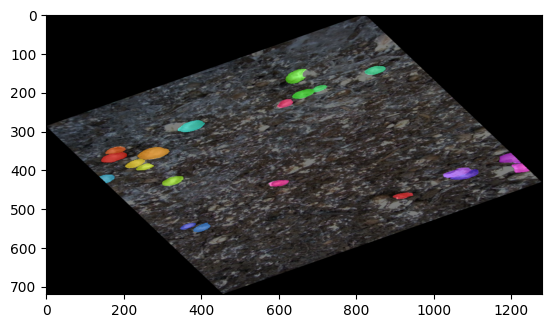

In [ ]:
boxes

In [ ]:
import albumentations as A

In [ ]:
images,targets = batch

In [ ]:
images

In [ ]:
model(images,targets)

In [8]:
import torch
import numpy as np
from PIL import Image
import os
import cv2

import numpy as np
import torch
import torchvision.transforms
from pycocotools.coco import COCO

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class M18KDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, train=True):
        self.root = root
        self.transforms = transforms
        self.annotations = COCO(os.path.join(root, "_annotations.coco.json"))
        self.train = True
    
    def augmentation(self, image, masks):
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomScale(0.1),
            A.Affine([0.8,1.2],[0.8,1.2],None,[-360, 360],[-45, 45],fit_output=True,p=1),
            A.Resize(720,1280)
        ])
    
        transformed = transform(image=image, masks=masks)
        transformed_image = transformed['image']
        transformed_mask = transformed['masks']
        
        return transformed_image,transformed_mask
    
    def __getitem__(self, idx):
        # load images and masks
        image_object = self.annotations.imgs[idx]
        img_path = image_object["file_name"]
        img = Image.open(os.path.join(self.root, img_path)).convert("RGB")
        W, H = img.size
        img = torchvision.transforms.ToTensor()(img)  # pixel_values

        masks = self.annotations.loadAnns(self.annotations.getAnnIds([image_object["id"]]))
        N = len(masks)  # Number of instances

        # Initialize tensors for mask_labels and class_labels
        mask_labels = torch.zeros((N, H, W), dtype=torch.uint8)
        class_labels = torch.zeros(N, dtype=torch.int64)
        for i, mask in enumerate(masks):
            mask_array = self.annotations.annToMask(mask)
            mask_tensor = torch.tensor(mask_array, dtype=torch.uint8)
            mask_labels[i] = mask_tensor
            class_labels[i] = mask["category_id"]

        # For pixel_mask, you can use a combined mask of all instances
        pixel_mask = torch.ones((H,W)).int()  # Convert to int for binary mask

        return {
            "pixel_values": img,
            "pixel_mask": pixel_mask,
            "mask_labels": mask_labels,
            "class_labels": class_labels
        }
    
    def __len__(self):
        return len(self.annotations.imgs)
    
ds = M18KDataset(root="M18K/Data/train",transforms=None)
ds[0]

loading annotations into memory...
Done (t=2.09s)
creating index...
index created!


{'pixel_values': tensor([[[0.2157, 0.2157, 0.2118,  ..., 0.5451, 0.5451, 0.6196],
          [0.2000, 0.2039, 0.2039,  ..., 0.5882, 0.5765, 0.6275],
          [0.2118, 0.2078, 0.1922,  ..., 0.5882, 0.5647, 0.5922],
          ...,
          [0.2549, 0.2745, 0.2510,  ..., 0.4588, 0.3059, 0.2588],
          [0.2588, 0.2627, 0.2471,  ..., 0.4510, 0.2980, 0.2510],
          [0.2667, 0.2510, 0.2431,  ..., 0.2667, 0.2235, 0.2902]],
 
         [[0.2353, 0.2353, 0.2196,  ..., 0.5490, 0.5529, 0.6275],
          [0.2196, 0.2235, 0.2118,  ..., 0.5922, 0.5804, 0.6353],
          [0.2196, 0.2157, 0.2000,  ..., 0.5961, 0.5765, 0.6039],
          ...,
          [0.2118, 0.2392, 0.2157,  ..., 0.4667, 0.3020, 0.2510],
          [0.2157, 0.2275, 0.2118,  ..., 0.4471, 0.2863, 0.2392],
          [0.2275, 0.2157, 0.2078,  ..., 0.2627, 0.2118, 0.2784]],
 
         [[0.2118, 0.2118, 0.2078,  ..., 0.4941, 0.4706, 0.5412],
          [0.1961, 0.2000, 0.2000,  ..., 0.5373, 0.5098, 0.5490],
          [0.2000, 0.196

pixel_values torch.Size([3, 720, 1280])
pixel_mask torch.Size([720, 1280])
mask_labels torch.Size([21, 720, 1280])
class_labels torch.Size([21])


In [4]:
from M18K.Data.Dataset import M18KDataset
from torch.utils.data import DataLoader
ds_train = M18KDataset("M18K/Data/train",None)

def collate_fn_torch(batch):
    return tuple(zip(*batch))

dl = DataLoader(ds_train,2,collate_fn=collate_fn_torch)

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


In [5]:
batch = next(iter(dl))
images, targets = batch


In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /Users/abdollah/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:02<00:00, 5.44MB/s]


AttributeError: 'SSD' object has no attribute 'roi_heads'

In [17]:
model.head.classification_head.module_list[0][0][0]

Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=672, bias=False)

In [18]:
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead

in_features = model.head.classification_head.module_list[0][0][0]
model.head.classification_head = SSDLiteClassificationHead()

TypeError: SSDLiteHead.__init__() missing 2 required positional arguments: 'num_anchors' and 'norm_layer'

In [23]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetHead

# load a model pre-trained on COCO



In [6]:
model.train()
model(images,targets)

{'loss_classifier': tensor(0.7604, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.5506, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.8677, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.1398, grad_fn=<DivBackward0>)}

In [20]:
from torchvision.models.detection import _utils as det_utils
from functools import partial
import torch.nn as nn
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead

in_channels = det_utils.retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer  = partial(nn.BatchNorm2d, eps=0.001, momentum=0.03)
num_classes = 2
model.head.classification_head = SSDLiteClassificationHead(in_channels, num_anchors, num_classes, norm_layer)

In [24]:
in_channels


[672, 480, 512, 256, 256, 128]

In [29]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2
model = retinanet_resnet50_fpn_v2(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 1 class (person) + background
# get number of input features for the classifier
num_anchors = model.head.classification_head.num_anchors
in_channels = model.head.classification_head.conv[0][0].in_channels

In [30]:
model.head.classification_head.conv[0][0].in_channels

256

In [32]:
det_utils.retrieve_out_channels(model.backbone, (720, 1280))

[256, 256, 256, 256, 256]

In [58]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.efficientnet_v2_s(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = MaskRCNN(
    backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [59]:
model(images,targets)

{'loss_classifier': tensor(1.0827, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1178, grad_fn=<DivBackward0>),
 'loss_mask': tensor(4.8060, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.7217, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.2322, grad_fn=<DivBackward0>)}

In [ ]:
model.

In [57]:
    from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): C

In [1]:
import pycocotools.cocoeval as cocoeval
import pycocotools.coco as coco

coco_gt = COCO()
coco_dt = coco_gt.loadRes(os.path.join(input_dir,'debug_pred.json'))

<module 'pycocotools.cocoeval' from '/Users/abdollah/miniconda3/envs/m18k/lib/python3.10/site-packages/pycocotools/cocoeval.py'>

In [ ]:
from pycocotools.coco import COCO

coco_gt = COCO("M18K/Data/test/_annotations.coco.json")
print("ok")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [2]:
pred = COCO(None)